<a href="https://colab.research.google.com/github/SreelathaChopparapu/EVA6/blob/main/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

Create a Neural Network that takes two inputs and produces two outputs as described below :

## Inputs :
1. Image from MNIST
2. Random Integer between 0-9

## Outputs :

1. MNIST label for the image
2. Addition of MNIST Digit & Random Number

![picture](https://drive.google.com/file/d/1vJDmSNH6pGrgBsYk19WAQVaBE_C9F0iI/view?usp=sharing)

In [2]:
# Standard Library Imports

import torch
import torchvision
import warnings
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision.transforms as transforms
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
from numpy.random import randint


warnings.filterwarnings('ignore')


## Dataset Loader

In [3]:
# Download MNIST Training
dataset = torchvision.datasets.MNIST(root= './data',
                                       train= True,
                                       download= True,
                                       transform= transforms.Compose([
                                                                      transforms.ToTensor()
                                       ]))
# Download MNIST TEST
test_set = torchvision.datasets.MNIST(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transforms.Compose([
                                                                    transforms.ToTensor()
                                      ]))

# Split to 80-20 for train-valid
lengths = [int(len(dataset)*0.8), int(len(dataset)*0.2)]
train_set, val_set = random_split(dataset, lengths)

# Hyper-parameter Initialisation
batch_size=128

# Load MNIST Train Data Loader
train_loader = torch.utils.data.DataLoader(train_set,
                                            batch_size= batch_size,
                                            shuffle= True,
                                            drop_last=True,
                                          pin_memory=True)

# Load MNIST Validation Data Loader
val_loader = torch.utils.data.DataLoader(val_set,
                                            batch_size= batch_size,
                                            shuffle= True,
                                            drop_last=True,
                                            pin_memory=True)

# Load MNIST Test Data Loader
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          pin_memory=True,
                                          drop_last=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


In [4]:
# Check Data for Each Class

print("Class & Data For Training Set : ")
print(dataset.targets.unique())
print(dataset.targets.bincount())
print()

print("Class & Data For Test Set : ")
print(test_set.targets.unique())
print(test_set.targets.bincount())


Class & Data For Training Set : 
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

Class & Data For Test Set : 
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])


## Model Architecture

In [5]:

# Defining the Model Architecture

class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3)
    self.conv5 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3)
    
    self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)

    self.fcl1 = nn.Linear(in_features=64*7*7,out_features=128)
    self.emb1 = nn.Linear(in_features=128,out_features=64)
    self.out1 = nn.Linear(in_features=64, out_features=10) # Output of the MNIST Image

    self.fcr1 = nn.Linear(in_features=74,out_features=128)
    self.emb2 = nn.Linear(in_features=128, out_features=256)
    self.out2 = nn.Linear(in_features=256, out_features=19) # Output of the Random Addition

  def forward(self,x1, x2):
    x1 = F.relu(self.conv2(F.relu(self.conv1(x1))))
    x1 = self.pool1(F.relu(self.conv3(x1)))
    x1 = F.relu(self.conv5(F.relu(self.conv4(x1))))
    x1 = x1.reshape(-1, 64*7*7)
    x1 = F.relu(self.fcl1(x1))
    x1 = F.relu(self.emb1(x1)) # Penulitmate Layer patterns/weights/embeddings
    out1 = self.out1(x1) # MNIST Prediction

    # Mix embeddings from the mnist convolutions
    combined = torch.cat([x1,x2], dim=1)  # Concatenating the Radom Input along Dim 1

    x2 = F.relu(self.fcr1(combined)) # FC layers for learning addition
    x2 = F.relu(self.emb2(x2))
    out2 = self.out2(x2)
   
    final_out = torch.cat([out1, out2], dim=1)

    return final_out

### Prediction of Final Layers

In [6]:
## prediction class
def class_predicted(preds, num_labels, sum_labels):
    num_preds = preds[:, :10]
    sum_preds = preds[:, 10:]   
    
    correct = torch.logical_and(num_preds.argmax(dim=1).eq(num_labels), sum_preds.argmax(dim=1).eq(sum_labels)).sum().item()
    
    return correct

### Loss Function

In [8]:
def custom_loss(preds, img_labels, sum_labels):
    num = preds[:, :10]
    sum = preds[:, 10:]

    num = F.log_softmax(num, dim=1)
    sum = F.log_softmax(sum, dim=1)
    
    num_loss = torch.nn.NLLLoss()(num, img_labels)
    sum_loss = torch.nn.NLLLoss()(sum, sum_labels)

    loss = num_loss + sum_loss

    return loss

### Training Loop

In [9]:
def train_and_eval(model, train_loader, val_loader, optimizer, criterion, num_epoch, device):
  train_losses = []
  val_losses = []
  for epoch in range(num_epoch):
    for split in ["train", "val"]:
        if split == "train":
            train_loss= 0
            train_correct= 0
            model.train()
            for images, labels in train_loader:
                optimizer.zero_grad()

                # MNIST Input & Label
                images = images.to(device)
                labels = labels.to(device)
                #   one_hot_labels = F.one_hot(labels, num_classes=10)

                # Create Random Number Input & Label 
                random_num = torch.randint(low=0, high=9, size=(batch_size,))
                random_num = random_num.to(device)
                random_inp = F.one_hot(random_num, num_classes=10)
                random_inp = random_inp.type(torch.float32)
                sum_labels = labels + random_num  
                #   one_hot_random = F.one_hot(random_labels, num_classes=18)
                random_inp = random_inp.to(device)
                
                # Forward Pass
                preds = model(images, random_inp)
                loss = criterion(preds, labels, sum_labels)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += class_predicted(preds, labels, sum_labels)

            print(f'Epoch:{epoch}\t {split.upper()}\t Correct Prediction:{train_correct}/{int(0.8*len(dataset))} \t Loss:{train_loss}')
            train_losses.append(train_loss)

        if split == "val":
            model.eval()
            val_loss = 0
            val_correct = 0
            for images, labels in val_loader:
                # MNIST Input & Label
                images = images.to(device)
                labels = labels.to(device)
                #   one_hot_labels = F.one_hot(labels, num_classes=10)

                # Create Random Number Input & Label 
                random_num = torch.randint(low=0, high=9, size=(batch_size,))
                random_num = random_num.to(device)
                random_inp = F.one_hot(random_num, num_classes=10)
                random_inp = random_inp.type(torch.float32)
                sum_labels = labels + random_num  
                #   one_hot_random = F.one_hot(random_labels, num_classes=18)
                
                random_inp = random_inp.to(device)

                with torch.no_grad():
                    preds = model(images, random_inp)                    
                    loss = criterion(preds, labels, sum_labels)

                    val_loss += loss.item()
                    val_correct += class_predicted(preds, labels, sum_labels)

            print(f'Epoch:{epoch}\t {split.upper()}\t Correct Prediction:{val_correct}/{int(0.2*len(dataset))} \t Loss:{val_loss}\n')
            print("=="*10)
            val_losses.append(val_loss)

  return model, train_losses, val_losses

## Model Initialisation & Training

In [10]:
# Model Initialisation
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model= Network()
model = model.train()
model = model.to(device)

print('Is model on GPU? ',next(model.parameters()).is_cuda)   ## check if model is moved to GPU

# Hyper-parameter Initialisation
batch_size=128
lr=0.003
num_epoch=20
optimizer = optim.Adam(model.parameters(),lr=lr)

# Training
finalWeights, train_losses, val_losses = train_and_eval(model, train_loader, val_loader, optimizer, custom_loss, num_epoch, device)

print(f"Training Accuracy: {round((47817/48000)*100, 2)}%")
print(f"Validation Accuracy: {round((11773/12000)*100, 2)}%")


cuda:0
Is model on GPU?  True
Epoch:0	 TRAIN	 Correct Prediction:29382/48000 	 Loss:535.6066573411226
Epoch:0	 VAL	 Correct Prediction:11503/12000 	 Loss:25.045962162315845

Epoch:1	 TRAIN	 Correct Prediction:46871/48000 	 Loss:60.121655033901334
Epoch:1	 VAL	 Correct Prediction:11601/12000 	 Loss:15.357773197814822

Epoch:2	 TRAIN	 Correct Prediction:47242/48000 	 Loss:38.52669954672456
Epoch:2	 VAL	 Correct Prediction:11662/12000 	 Loss:12.643219413235784

Epoch:3	 TRAIN	 Correct Prediction:47381/48000 	 Loss:30.353497132426128
Epoch:3	 VAL	 Correct Prediction:11617/12000 	 Loss:13.947965221479535

Epoch:4	 TRAIN	 Correct Prediction:47460/48000 	 Loss:25.46136584575288
Epoch:4	 VAL	 Correct Prediction:11674/12000 	 Loss:12.721524040214717

Epoch:5	 TRAIN	 Correct Prediction:47517/48000 	 Loss:22.65616480866447
Epoch:5	 VAL	 Correct Prediction:11702/12000 	 Loss:11.431833983864635

Epoch:6	 TRAIN	 Correct Prediction:47620/48000 	 Loss:17.590255036833696
Epoch:6	 VAL	 Correct Predictio

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model Evaluation

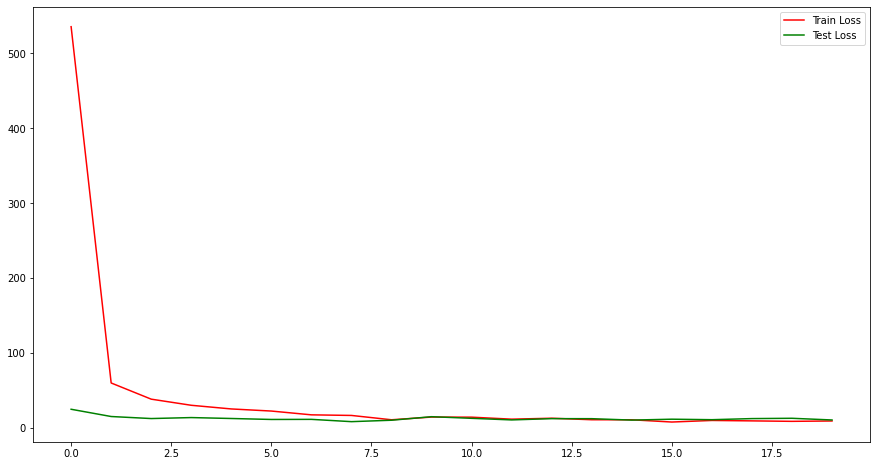

In [13]:
# Track & Plot Losses

import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(train_losses, color="red", label="Train Loss")
plt.plot(val_losses, color="green", label="Test Loss")
plt.legend()
plt.show()

In [14]:
# Track on Test Set

model.eval()
test_loss = 0
test_correct = 0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    #   one_hot_labels = F.one_hot(labels, num_classes=10)

    random_num = torch.randint(low=0, high=9, size=(batch_size,))
    random_num = random_num.to(device)
    random_inp = F.one_hot(random_num, num_classes=10)
    random_inp = random_inp.type(torch.float32)
    sum_labels = labels + random_num  
    #   one_hot_random = F.one_hot(random_labels, num_classes=18)
    
    random_inp = random_inp.to(device)

    with torch.no_grad():
        preds = model(images, random_inp)                    
        test_correct += class_predicted(preds, labels, sum_labels)

print(f'{"TEST"}\t Correct Predictions:{test_correct}/{int(len(test_set))}\n')
print(f"Accuracy: {test_correct/int(len(test_set))*100}%")
print("=="*10)


TEST	 Correct Predictions:9888/10000

Accuracy: 98.88%


In [15]:
import torch.onnx

In [16]:
# Single Item Inference/Prediction

def test_one_item():
    batch = next(iter(test_loader))
    images,label = batch
    images = images.to(device)[0].unsqueeze(dim=0)
    label = label.to(device)[0].unsqueeze(dim=0)

    random_num = torch.randint(low=0, high=9, size=(1,))
    random_num = random_num.to(device)
    random_inp = F.one_hot(random_num, num_classes=10)
    random_inp = random_inp.type(torch.float32)
    sum_labels = label + random_num 
    print(f"MNIST number: {label.item()}")
    print(f"Random number: {random_num.item()}")
    print(f"Sum: {sum_labels.item()}")

    print("="*10)
    global model
    with torch.no_grad():
        model = model.eval()
        preds = model(images, random_inp)
        num, sum = preds[:,:10], preds[:, 10:]
    print(f"Predicted Number {torch.argmax(num)}")
    print(f"Predicted Sum {torch.argmax(sum)}")
    torch.onnx.export(model,               # model being run
                  (images, random_inp),                         # model input (or a tuple for multiple inputs)
                  "model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})
    
    # print(f'Test Prdiction:{class_predicted(preds,label)}')

# Single Prediction/Inference
test_one_item()

MNIST number: 7
Random number: 8
Sum: 15
Predicted Number 7
Predicted Sum 15
